<!-- mission_number=3 file_list=[] mode="multiscreen" -->

# Introduction
## Using logistic regression to predict admissions
### TJ Vandal


<!-- type="code" -->

# Introduction to the Data

Logistic regression is used in a variety of field and applications for binary classification. To grasp the concepts of logisti regression we will be analyzing a synthetic dataset created by a group at UCLA to simulate admissions criteria for graduate school of 400 applicants. Our goal is to predict whether a student will be admitted given GPA, GRE scores, and class school rank. 

gre - Graduate Record Exam, a generalized test for prospective graduate students, continuous <br>
gpa - Cumulative grade point average, continuous <br>
rank - Prestige of undergraduate school, discrete <br>
admit - Binary variable, 0 or 1, where 1 means the applicant was admitted to the program

This lesson and data are taken from http://blog.yhathq.com/posts/logistic-regression-and-python.html. 

## Visualize and Describe the data

The first part of any data analysis is to gain a basic insights about the data. Visualizations and summarizations of the data are effective. More often than not these basic insights provide valuable information pertaining to the direction of the analysis. By plotting histograms of each variable we get an understanding of the distributions. 

            admit         gre         gpa       rank
count  400.000000  400.000000  400.000000  400.00000
mean     0.317500  587.700000    3.389900    2.48500
std      0.466087  115.516536    0.380567    0.94446
min      0.000000  220.000000    2.260000    1.00000
25%      0.000000  520.000000    3.130000    2.00000
50%      0.000000  580.000000    3.395000    2.00000
75%      1.000000  660.000000    3.670000    3.00000
max      1.000000  800.000000    4.000000    4.00000


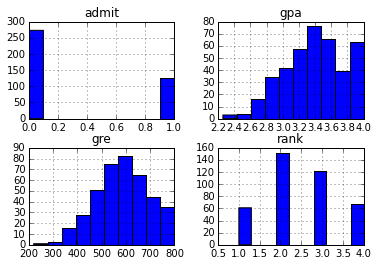

In [44]:
# Load relevent libraries
%matplotlib inline
import pandas
import matplotlib.pyplot as plt

# Load admissions data
admissions = pandas.read_csv("admissions.csv")

# Describe the data
print(admissions.describe())

# Visualize by plotting gre, gpa, and rank against admit
admissions.hist()
plt.show()

<!-- type="code" -->

# Logistic Regression

Logistic regression is a popular method to predict binary outputs by constraining the model's output between 0 and 1. This output can be viewed as the probability of an event given a set of inputs. The single variable logistic regression model is defined as,

<center>$\pi_i=\dfrac{e^{\beta_0+\beta_1x_i}}{1+e^{\beta_0+\beta_1x_i}}$ where $y_i\stackrel{ind}\sim Bernoulli(\pi_i)$

A random variable that follows the Bernoulli distribution takes value 1 with success probability p and value 0 with failure probability q=1-p. 

Similar to a linear regression model, we want to compute the optimal values for $\beta_0$ and $\beta_1$ to minimize the the error between the output and true value. Maximim likelihood method and gradient decent are methods used to approximate these coefficients. We will be applying the maximum likelihood estimation method in this lesson.

To get a better understanding of the logistic function, $\sigma(t)=\dfrac{e^t}{1+e^t}$, by varying $t$. We see a function which is "s-shaped" and constrained between 0 and 1. These attributes make the logistic function able to predict a binary output. 

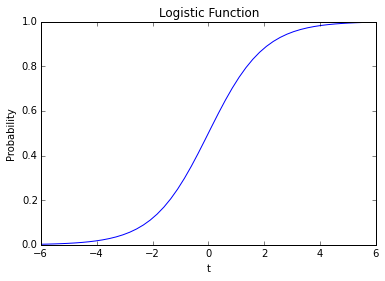

In [45]:
import numpy

# Logistic Function
def logitistic(x):
    return numpy.exp(x) / (1 + numpy.exp(x)) 

# Create an array with 50 values between -6 and 6 as t
t = numpy.linspace(-6,6,50, dtype=float)

# Get logistic fits
ylogistic = logitistic(t)

# plot the logistic function
plt.plot(t, ylogistic, label="logistic")
plt.ylabel("Probability")
plt.xlabel("t")
plt.title("Logistic Function")
plt.show()


# Dummy Variables

Categorical variables must be transformed appropriately to dummy variables. In our example the class rank is considered a categorical variable, these categories are 1, 2, 3, and 4. 

Pandas has a great function, get_dummies, which easily transforms these categories into binary features. With 4 categories there are 3 degrees of freedom so we choose the last 3 columns of dummy features to add to our dataset. 


In [62]:
## create dataframe of dummy variables
dummies = pandas.get_dummies(admissions['rank'], prefix='rank')

## join last 3 columns to admissions dataframe and remove rank column
data = admissions.join(dummies.ix[:, 1:])
del data['rank']
print(data.head())

   admit  gre   gpa  rank_2  rank_3  rank_4
0      0  380  3.61       0       1       0
1      1  660  3.67       0       1       0
2      1  800  4.00       0       0       0
3      1  640  3.19       0       0       1
4      0  520  2.93       0       0       1


# Model Data

Lets try to predict admission using the logistic regression model. The first 300 observations will be for training the model and the rest will be used for testing. 

The statsmodels library is used to fit our model with maximum likelihood estimation. Maximum likelihood will be covered in future lessons. A summarization of the model can be shown by using the summary function on the model fit. Here we are able to look at the residuals, p-values, AIC, BIC, and other statistical information for further interpretation. 


In [60]:
import statsmodels.api as sm

## add a column of ones to allow the model to have an intercept
data['ones'] = 1.0

## train with 300 and test with the following 100, split dataset 
num_train = 300
data_train = data[:num_train]
data_test = data[num_train:]

## Fit Logistic regression with admit ~ gre using the training set
train_cols = data_train.columns[1:]
model = sm.Logit(data_train['admit'], data_train[train_cols])
res = model.fit()

## summary of our model
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.546708
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  300
Model:                          Logit   Df Residuals:                      294
Method:                           MLE   Df Model:                            5
Date:                Tue, 19 May 2015   Pseudo R-squ.:                  0.1131
Time:                        22:40:47   Log-Likelihood:                -164.01
converged:                       True   LL-Null:                       -184.92
                                        LLR p-value:                 6.406e-08
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
gre            0.0030      0.001      2.346      0.019         0.000     0.006
gpa            0.9316      0.

# Odds Ratio

The odds ratio allows for interpretation of the feature coefficients. The ratio is defined as $$OR=\dfrac{e^{\beta_0 + \beta_1(x+1)}}{e^{\beta_0 + \beta_1(x)}} = e^{\beta_1}$$

In words, the odds ratio tells us how much more/less likely one is to be admitted to a university per unit increase in a x. For example, $\beta_{gpa}=0.9316$ so the probability of admission increases by $e^{0.9316}-1$, or 153%, per 1 point increase in gpa. 

In [64]:
## compute odds ratios
print(numpy.exp(res.params))

gre       1.003025
gpa       2.538608
rank_2    0.535369
rank_3    0.213643
rank_4    0.185479
ones      0.007607
dtype: float64


# How good is our prediction?

In practice, more often than not, the prediction accuracy will be the most important result. A test set is used to minimize the bias produced by the data in our model. For simplicity, we will say if the probability of admission is greater than 0.5 then the applicant was admitted. 

During the data summarization step we found that 68% of applications are not admitted.  With an accuracy of 67% on the test set, we have not gained any predictive power over chance. In this case, we should find more features to explain the data or find a more suitable model. 

In [79]:
## Training set accuracy
predicted = res.predict(data_train[train_cols]) > 0.50
accuracy_train = (predicted == data_train['admit']).mean()
print("Accuracy in Training Set = %f" % accuracy_train)

## Test set accuracy
predicted = res.predict(data_test[train_cols]) > 0.50
accuracy_test = (predicted == data_test['admit']).mean()
print("Accuracy in Test Set = %f" % accuracy_test)


Accuracy in Training Set = 0.716667
Accuracy in Test Set = 0.670000


# Conclusions

In this lesson we covered the basics in logistic regression by using statsmodels. The odds ratio was shown to provide interpretability to our results. We have shown that the predictive power of our model is no better than chance and more advanced methods may be suitable. 

In future lessons we will show how to interpret some of the statistical information given by the model's summary as well as other methods to evaluate the predictive power. 